# Multi-Object Tracking Evaluation Notebook
This notebook implements the workflow to evaluate Deep SORT or bytetrack tracking outputs
against a manually annotated ground truth (MOTChallenge style).

In [233]:
import os
import pandas as pd
import numpy as np
import json
import motmetrics as mm
import matplotlib.pyplot as plt

In [234]:
#dataset_name = 'recording_2025-05-14'
dataset_name = 'test_ride_niek'

GT_CSV    = f'{dataset_name}_reviewed.csv'
PRED_CSV  = f'{dataset_name}_tracks_ma30_bytetrack.csv'
ANNOT_JSON= f'{dataset_name}.json'
DATA_DIR  = dataset_name
ALLOWED_CATEGORIES = [3, 4, 5]  # Categories to consider for evaluation
MAX_IOU_DISTANCE = 0.5  # threshold for IoU matching

## 2. Data Loading Functions

In [235]:
def load_ground_truth(gt_csv):
    '''
    Load manual annotations and return a DataFrame with columns:
    ['image_name','gt_id','object_category'].
    Adjusts object_category from 0-4 to 1-5 to match predictions/JSON.
    '''
    df = pd.read_csv(gt_csv)
    df = df.rename(columns={'ID': 'gt_id'})
    # Shift object_category by +1 to align 0-4 → 1-5
    df['object_category'] = df['object_category'] + 1
    return df[['image_name', 'gt_id', 'object_category']]

def load_predictions(pred_csv):
    """
    Load tracker outputs and return a DataFrame with columns:
    ['image_name','trk_id','object_category','annotation_id'].
    Strips any directory prefix by taking basename.
    """
    df = pd.read_csv(pred_csv)
    df = df.rename(columns={'ID':'trk_id'})
    df['image_name'] = df['image_name'].apply(os.path.basename)
    return df[['image_name','trk_id','object_category','annotation_id']]

## 3. Frame Index Mapping

In [236]:
def assign_frame_indices(gt_df, pr_df):
    '''
    Create a global mapping from image_name to a consecutive frame index,
    based on sorted unique image_name values across GT and predictions.
    '''
    unique_names = sorted(set(gt_df['image_name']).union(pr_df['image_name']))
    name_to_frame = {name: idx+1 for idx, name in enumerate(unique_names)}
    # Apply mapping
    gt_df['frame'] = gt_df['image_name'].map(name_to_frame)
    pr_df['frame'] = pr_df['image_name'].map(name_to_frame)
    return gt_df, pr_df

## 4. Fetching Bounding Boxes from COCO Annotations

In [ ]:
def load_coco_bboxes(ann_json_path, allowed_categories=None):
    """
    Load COCO annotations JSON and return a DataFrame with columns:
    ['image_name','x1','y1','x2','y2','category_id','annotation_id'].
    Converts normalized bboxes to pixel coords using image width/height.
    Strips any directory prefix by taking basename of file_name.
    """
    coco = json.load(open(ann_json_path, 'r'))
    img_meta = {img['id']: img for img in coco['images']}
    records = []
    for ann in coco['annotations']:
        cid = ann['category_id']
        if allowed_categories and cid not in allowed_categories:
            continue
        img = img_meta.get(ann['image_id'])
        if img is None:
            continue
        w_img, h_img = img['width'], img['height']
        x, y, bw, bh = ann['bbox']  # normalized [0-1]
        px, py = int(x * w_img), int(y * h_img)
        pw, ph = int(bw * w_img), int(bh * h_img)
        fn = os.path.basename(img['file_name'])
        records.append({
            'image_name': fn,
            'x1': px, 'y1': py,
            'x2': px + pw, 'y2': py + ph,
            'category_id': cid,
            'annotation_id': ann['id']
        })
    return pd.DataFrame(records)

def attach_bboxes(df, ann_df, key_cols=('image_name','object_category')):
    """
    For each row in df, find all matching ann_df rows on key_cols,
    pick one at random (if any), and attach its bbox + annotation_id.
    If no match, fill with NaN.
    
    df must have columns matching key_cols ('object_category' in df 
    corresponds to 'category_id' in ann_df).
    ann_df must have ['image_name','category_id','x1','y1','x2','y2','annotation_id'].
    """
    # rename for uniformity
    ann = ann_df.rename(columns={'category_id': 'object_category'})
    # build groups
    groups = ann.groupby(list(key_cols))

    # preallocate columns
    out = df.copy()
    out[['x1','y1','x2','y2','annotation_id']] = np.nan

    # for reproducibility
    rng = np.random.default_rng(seed=42)

    # for each unique key tuple, sample once and broadcast
    for keys, subidx in out.groupby(list(key_cols)).groups.items():
        # keys is a tuple (image_name, object_category)
        # get candidate bboxes
        try:
            candidates = groups.get_group(keys)
        except KeyError:
            # no JSON bbox for this key
            continue
        # choose one row at random
        chosen = candidates.sample(n=1, random_state=rng).iloc[0]
        # assign to all matching df rows
        mask = (out['image_name'] == keys[0]) & (out['object_category'] == keys[1])
        out.loc[mask, ['x1','y1','x2','y2','annotation_id']] = \
            chosen[['x1','y1','x2','y2','annotation_id']].values

    return out

In [238]:
if __name__ == '__main__':
    # Load and prepare data
    gt_df = load_ground_truth(GT_CSV)
    pr_df = load_predictions(PRED_CSV)
    # Check how many rows are in gt_df with no filter and how many with ALLOWED_CATEGORIES filter
    print("Ground Truth before merging:", len(gt_df))
    print("Predictions before merging:", len(pr_df))
    gt_df, pr_df = assign_frame_indices(gt_df, pr_df)
    ann_df = load_coco_bboxes(ANNOT_JSON, allowed_categories=ALLOWED_CATEGORIES)
    # DEBUG: check what actually landed in ann_df
    print("JSON categories present:", sorted(ann_df['category_id'].unique()))
    print("CSV categories present:", sorted(gt_df['object_category'].unique()))
    print("Pred CSV categories present:", sorted(pr_df['object_category'].unique()))
    print("Counts by category:\n", ann_df['category_id'].value_counts())
    # Sum the value counts to verify
    print("Total annotations loaded:", len(ann_df))
    
    gt_counts  = gt_df.groupby('image_name').size().rename('gt_count')
    pr_counts  = pr_df.groupby('image_name').size().rename('pred_count')
    ann_counts = ann_df.groupby('image_name').size().rename('ann_count')

    # 2. Find mismatches (where GT rows ≠ JSON bboxes)
    counts_df = pd.concat([gt_counts, pr_counts, ann_counts], axis=1).fillna(0).astype(int)
    counts_df['image_name'] = counts_df.index
    counts_df.reset_index(drop=True, inplace=True)
    
    # 3. Find frames with gt_count > ann_count
    gt_gt_ann = counts_df[counts_df['gt_count'] > counts_df['ann_count']]
    mismatch_df = counts_df[counts_df['gt_count'] != counts_df['ann_count']]
    

    print(f"Frames with GT ≠ ann (total {len(mismatch_df)}):")
    print(f"Frames with GT > ann (total {len(gt_gt_ann)}):")
    print(gt_gt_ann.sort_values(['ann_count','gt_count'], ascending=False).head(30))
    print(mismatch_df.sort_values(['ann_count','gt_count'], ascending=False).head(50))
    
    print(ann_df.columns)

Ground Truth before merging: 708
Predictions before merging: 303
JSON categories present: [3, 4, 5]
CSV categories present: [3, 4, 5]
Pred CSV categories present: [3, 4, 5]
Counts by category:
 category_id
3    343
5    200
4    159
Name: count, dtype: int64
Total annotations loaded: 702
Frames with GT ≠ ann (total 61):
Frames with GT > ann (total 25):
     gt_count  pred_count  ann_count                        image_name
329         7           5          6  detection_20250514_123516421.jpg
330         7           3          6  detection_20250514_123516954.jpg
325         7           2          5  detection_20250514_123514302.jpg
324         6           1          5  detection_20250514_123513792.jpg
326         6           3          5  detection_20250514_123514806.jpg
327         6           0          5  detection_20250514_123515355.jpg
328         6           2          5  detection_20250514_123515892.jpg
95          4           1          3  detection_20250514_122314267.jpg
96    

In [240]:
# Print len of DataFrames to check differences before and after merging
print("Ground Truth with Frames & BBoxes:\n", len(gt_df))
print("Predictions with Frames & BBoxes:\n", len(pr_df))

gt_df = attach_bboxes(gt_df, ann_df.rename(columns={'category_id':'object_category'}), 
                         key_cols=('image_name','object_category'))
pr_df = pr_df.merge(ann_df[['annotation_id','x1','y1','x2','y2']], on='annotation_id', how='left')

print("After merge, GT rows:", len(gt_df))
print("   any missing bboxes:", gt_df[['x1','y1','x2','y2']].isnull().any(axis=1).sum())

print(len(gt_df), "ground truth records loaded.")
print(len(pr_df), "predictions loaded.")

# Amount of unique objects in GT csv
unique_gt_ids = gt_df['gt_id'].nunique()
print(f"Unique GT objects: {unique_gt_ids}")

# Amount of unique objects in predictions
unique_pr_ids = pr_df['trk_id'].nunique()
print(f"Unique predicted objects: {unique_pr_ids}")

Ground Truth with Frames & BBoxes:
 708
Predictions with Frames & BBoxes:
 303
After merge, GT rows: 708
   any missing bboxes: 18
708 ground truth records loaded.
303 predictions loaded.
Unique GT objects: 48
Unique predicted objects: 74


## 5. Frame-by-Frame Matching and Accumulation

In [241]:
# Helper for IoU-based cost
from motmetrics.distances import iou_matrix

# Initialize accumulator
acc = mm.MOTAccumulator(auto_id=True)

all_ious = []

# Iterate over each frame in the ground truth
for frame in sorted(gt_df['frame'].unique()):
    gt_frame = gt_df[gt_df['frame'] == frame]
    pr_frame = pr_df[pr_df['frame'] == frame]

    gt_ids = gt_frame['gt_id'].tolist()
    pr_ids = pr_frame['trk_id'].tolist()

    # Extract bounding boxes in [x1,y1,x2,y2]
    gt_boxes = gt_frame[['x1','y1','x2','y2']].values
    pr_boxes = pr_frame[['x1','y1','x2','y2']].values

    # Compute cost matrix based on IoU
    if len(gt_boxes) > 0 and len(pr_boxes) > 0:
        # Compute IoU matrix, then cost = 1 - IoU
        iou_mat = iou_matrix(gt_boxes, pr_boxes, max_iou=MAX_IOU_DISTANCE) # unmatched pairs get cost > MAX_IOU_DISTANCE
        cost_mat = 1 - iou_mat
    else:
        cost_mat = np.empty((len(gt_boxes), len(pr_boxes)))

    # Update accumulator: unmatched rows/cols are handled internally
    acc.update(gt_ids, pr_ids, cost_mat)

print("Accumulation complete. Total frames processed:", len(sorted(gt_df['frame'].unique())))

Accumulation complete. Total frames processed: 373


## 5.1 Diagnostic: Accumulator Event Summary

In [242]:
# Fetch all accumulator events and print counts by type
# In newer motmetrics versions, events are stored in `acc.events`
events = getattr(acc, 'events', None)
if events is None:
    # Fallback: try private attribute
    events = acc._events  # DataFrame stored internally
print("Accumulator Event Types and Counts:")
print(events['Type'].value_counts())
print("Sample Events (first 10 rows):")
print(events.head(10))

Accumulator Event Types and Counts:
Type
RAW         1203
MISS         441
MATCH        194
SWITCH        73
ASCEND        44
TRANSFER      37
FP            36
MIGRATE       16
Name: count, dtype: int64
Sample Events (first 10 rows):
                Type  OId  HId    D
FrameId Event                      
0       0        RAW  NaN  NaN  NaN
        1        RAW  1.0  1.0  1.0
        2      MATCH  1.0  1.0  1.0
1       0        RAW  NaN  NaN  NaN
        1        RAW  1.0  1.0  1.0
        2      MATCH  1.0  1.0  1.0
2       0        RAW  NaN  NaN  NaN
        1        RAW  1.0  1.0  1.0
        2      MATCH  1.0  1.0  1.0
3       0        RAW  NaN  NaN  NaN


In [243]:
# 1. Check for any missing bounding boxes after merge
print("Ground truth entries without bboxes:", gt_df[['x1','y1','x2','y2']].isnull().any(axis=1).sum())
print("Prediction entries without bboxes:", pr_df[['x1','y1','x2','y2']].isnull().any(axis=1).sum())

# 2. Frames with GT but no predictions (all false negatives)
frames_no_pred = sorted(set(gt_df['frame']) - set(pr_df['frame']))
print(f"Frames with GT but no preds: {len(frames_no_pred)} frames (e.g. {frames_no_pred[:5]})")

# 3. Frames with predictions but no GT (all false positives)
frames_no_gt = sorted(set(pr_df['frame']) - set(gt_df['frame']))
print(f"Frames with preds but no GT: {len(frames_no_gt)} frames (e.g. {frames_no_gt[:5]})")

# 4. Distribution of object counts per frame
cnt_gt = gt_df.groupby('frame').size()
cnt_pr = pr_df.groupby('frame').size()
print("GT objects per frame: min, max, mean =", cnt_gt.min(), cnt_gt.max(), cnt_gt.mean())
print("Pred objects per frame: min, max, mean =", cnt_pr.min(), cnt_pr.max(), cnt_pr.mean())

# 5. Sample IoU values to spot mismatches
# For a frame that exists in both GT and predictions
common_frames = sorted(set(gt_df['frame']).intersection(pr_df['frame']))
if common_frames:
    sample_frame = common_frames[0]  # pick the first shared frame
    gt_sample = gt_df[gt_df.frame==sample_frame][['x1','y1','x2','y2']].values
    pr_sample = pr_df[pr_df.frame==sample_frame][['x1','y1','x2','y2']].values
    iou_sample = iou_matrix(gt_sample, pr_sample, max_iou=1.0)
    print(f"Sample IoU matrix for frame {sample_frame}:", np.round(iou_sample,2))
else:
    print("No overlapping frames for IoU sampling.")

Ground truth entries without bboxes: 18
Prediction entries without bboxes: 0
Frames with GT but no preds: 157 frames (e.g. [20, 21, 22, 23, 24])
Frames with preds but no GT: 0 frames (e.g. [])
GT objects per frame: min, max, mean = 1 7 1.8981233243967828
Pred objects per frame: min, max, mean = 1 5 1.4027777777777777
Sample IoU matrix for frame 1: [[0.]]


## 5.3 Visualize Sample Frame with GT vs. Predictions

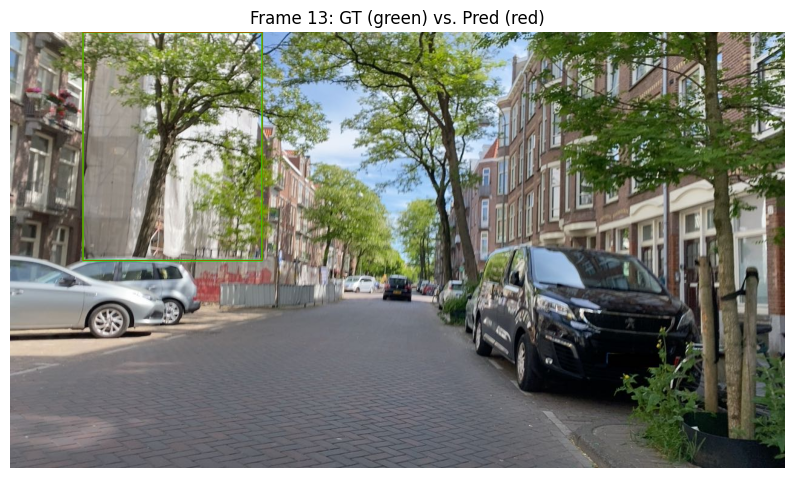

IoU matrix for frame 13: [[0.]]


In [244]:
import cv2
# Determine a sample frame with both GT and predictions
common_frames = sorted(set(gt_df['frame']).intersection(pr_df['frame']))
if common_frames:
    # pick a random common frame
    import random
    # Randomly select a frame from the common frames
    sample_frame = random.choice(common_frames)
    # Fetch image filename for this frame
    img_name = gt_df[gt_df.frame == sample_frame]['image_name'].iloc[0]
    # Build full path to frame (adjust DATA_DIR as needed)
    img_path = os.path.join(DATA_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image at {img_path}")
    else:
        # Draw GT boxes in green
        gt_boxes = gt_df[gt_df.frame == sample_frame][['x1','y1','x2','y2']].values
        for (x1,y1,x2,y2) in gt_boxes:
            cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
        # Draw Pred boxes in red
        pr_boxes = pr_df[pr_df.frame == sample_frame][['x1','y1','x2','y2']].values
        for (x1,y1,x2,y2) in pr_boxes:
            cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255), 1)
        # Display with matplotlib
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {sample_frame}: GT (green) vs. Pred (red)")
        plt.axis('off')
        plt.show()
        # Print IoU matrix
        iou_mat = iou_matrix(gt_boxes, pr_boxes, max_iou=1.0)
        print(f"IoU matrix for frame {sample_frame}:", np.round(iou_mat,2))
else:
    print("No common frames to visualize.")

## 5. Compute Tracking-Only Metrics

In [245]:
mh = mm.metrics.create()
metrics = ['idf1',    # ID F1‐score (X% of the time tracker’s IDs match the ground truth over all frames)
           'num_switches',  # total ID switches
           'mostly_tracked', # MT (# of GT tracks tracked for at least 80% of their lifespan)
           'mostly_lost']    # ML (# of GT tracks tracked for less than 20% of their lifespan)
summary_id = mh.compute(
    acc,
    metrics=metrics,
    name='ID-Only'
)
print(mm.io.render_summary(summary_id))

             idf1  num_switches  mostly_tracked  mostly_lost
ID-Only  0.342235            73               4           17


## 6. Side-by-Side Frame-by-Frame Visualization

In [ ]:
# Display each frame with GT boxes on the left and prediction boxes on the right, with a slider to navigate.
import ipywidgets as widgets
from IPython.display import display, clear_output

# Ensure images load correctly

# Visualization function
def display_frame_side_by_side(frame):
    clear_output(wait=True)
    # Find image name for this frame
    img_name = gt_df.loc[gt_df.frame == frame, 'image_name'].iloc[0]
    img_path = os.path.join(DATA_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image for frame {frame}: {img_path}")
        return
    # Prepare copies
    vis_gt = img.copy()
    vis_pr = img.copy()
    # Draw GT boxes (green)
    for _, row in gt_df[gt_df.frame == frame].iterrows():
        if row[['x1','y1','x2','y2']].isnull().any():
            continue
        x1, y1, x2, y2 = map(int, row[['x1','y1','x2','y2']])
        cv2.rectangle(vis_gt, (x1, y1), (x2, y2), (0,255,0), 2)
    # Draw Pred boxes (red) with IDs
    font       = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    thickness  = 1
    for _, row in pr_df[pr_df.frame == frame].iterrows():
        x1, y1, x2, y2 = map(int, row[['x1','y1','x2','y2']])
        trk_id = str(row['trk_id'])

        # Draw the box
        cv2.rectangle(vis_pr, (x1, y1), (x2, y2), (0,0,255), 2)

        # Measure text size so we can adjust if it would go outside
        (text_w, text_h), baseline = cv2.getTextSize(trk_id, font, font_scale, thickness)

        # Try to put text above the box; if not enough space, put it below
        text_x = x1
        if y1 - text_h - baseline > 0:
            text_y = y1 - baseline
        else:
            text_y = y1 + text_h + baseline

        # Clamp horizontally so text doesn’t overflow
        text_x = max(0, min(text_x, vis_pr.shape[1] - text_w))

        # Finally, draw the text background for readability (optional)
        cv2.rectangle(vis_pr,
                      (text_x, text_y - text_h - baseline),
                      (text_x + text_w, text_y + baseline),
                      (255,255,255), 
                      thickness=cv2.FILLED)
        # Draw the ID text in red
        cv2.putText(vis_pr, trk_id, (text_x, text_y), font, font_scale, (0,0,255), thickness)
    # Plot side by side
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    axes[0].imshow(cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Frame {frame} GT')
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(vis_pr, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Frame {frame} Pred')
    axes[1].axis('off')
    plt.show()

# Slider to navigate frames
total_frames = sorted(gt_df['frame'].unique())
frame_slider = widgets.SelectionSlider(
    options=total_frames,
    description='Frame:',
    continuous_update=False
)
widgets.interact(display_frame_side_by_side, frame=frame_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Frame:', options=(1, 2, 3, 4, 5, 6…

<function __main__.display_frame_side_by_side(frame)>

## 7. Batch Analysis of Sweep Results

In [ ]:
# Read all swept tracker CSVs, compute ID-only metrics, and summarize
import glob

out_dir = '.' # Directory where results CSVs are stored

# Prepare GT + annotations once
gt_df_base = load_ground_truth(GT_CSV)
# Assign frame indices using only the GT image list
unique_frames = sorted(gt_df_base['image_name'].unique())
frame_map = {name: idx+1 for idx, name in enumerate(unique_frames)}
gt_df_base['frame'] = gt_df_base['image_name'].map(frame_map)
ann_df = load_coco_bboxes(ANNOT_JSON, allowed_categories=ALLOWED_CATEGORIES)
gt_df_base, _ = merge_bboxes(gt_df_base, pd.DataFrame({'image_name':[], 'trk_id':[], 'object_category':[]}), ann_df)

# Collect results
records = []
csv_path = glob.glob(os.path.join(out_dir, f'{DATA_DIR}_tracks_*.csv'))
for path in sorted(glob.glob(os.path.join(out_dir, 'tracks_*.csv'))):
    # parse parameters from filename: tracks_ma{ma}_cd{cd}_ni{ni}.csv
    fname = os.path.basename(path)
    parts = fname.rstrip('.csv').split('_')
    ma = int(parts[1].lstrip('ma'))
    cd = int(parts[2].lstrip('cd'))/100.0
    ni = int(parts[3].lstrip('ni'))

    # **Load this sweep’s predictions**
    pr_df_i = load_predictions(path)
    pr_df_i['frame'] = pr_df_i['image_name'].map(frame_map)
    _, pr_df_i = merge_bboxes(gt_df_base, pr_df_i, ann_df)

    # accumulate
    acc_i = mm.MOTAccumulator(auto_id=True)
    for frame in sorted(gt_df_base['frame'].unique()):
        gt_frame = gt_df_base[gt_df_base['frame']==frame]
        pr_frame = pr_df_i[pr_df_i['frame']==frame]
        gt_ids = gt_frame['gt_id'].tolist()
        pr_ids = pr_frame['trk_id'].tolist()
        gt_boxes = gt_frame[['x1','y1','x2','y2']].values
        pr_boxes = pr_frame[['x1','y1','x2','y2']].values
        if len(gt_boxes)>0 and len(pr_boxes)>0:
            iou_mat = iou_matrix(gt_boxes, pr_boxes, max_iou=MAX_IOU_DISTANCE)
            cost_mat = 1.0 - iou_mat
        else:
            cost_mat = np.empty((len(gt_boxes), len(pr_boxes)))
        acc_i.update(gt_ids, pr_ids, cost_mat)

    # compute metrics
    mh = mm.metrics.create()
    summary = mh.compute(acc_i, metrics=['idf1','num_switches','mostly_tracked','mostly_lost'], name=fname)
    row = summary.iloc[0].to_dict()
    row.update({'max_age': ma, 'max_cosine_dist': cd, 'n_init': ni})
    records.append(row)

# Build results DataFrame
results_df = pd.DataFrame(records)

In [ ]:
# Display results table
print("Parameter Sweep Results:")
print(results_df)
# Optionally, plot idf1 as function of max_age
plt.figure(figsize=(8,4))
for cd in sorted(results_df['max_cosine_dist'].unique()):
    sub = results_df[results_df['max_cosine_dist']==cd]
    plt.plot(sub['max_age'], sub['idf1'], marker='o', label=f"cd={cd}")
plt.xlabel('max_age')
plt.ylabel('IDF1')
plt.title('IDF1 vs max_age for different cosine thresholds')
plt.legend()
plt.show()
# plot idf1 as function of n_init
plt.figure(figsize=(8,4))
for cd in sorted(results_df['max_cosine_dist'].unique()):
    sub = results_df[results_df['max_cosine_dist']==cd]
    plt.plot(sub['n_init'], sub['idf1'], marker='o', label=f"cd={cd}")
plt.xlabel('n_init')
plt.ylabel('IDF1')
plt.title('IDF1 vs n_init for different cosine thresholds')
plt.legend()
plt.show()
# plot idf1 as function of max_cosine_dist
plt.figure(figsize=(8,4))
for ma in sorted(results_df['max_age'].unique()):
    sub = results_df[results_df['max_age']==ma]
    plt.plot(sub['max_cosine_dist'], sub['idf1'], marker='o', label=f"ma={ma}")
plt.xlabel('max_cosine_dist')
plt.ylabel('IDF1')
plt.title('IDF1 vs max_cosine_dist for different max_age values')
plt.legend()
plt.show()

## 8. Heatmap Visualizations of Sweep Results

In [ ]:
import seaborn as sns

# 8.1 Heatmap of IDF1 over max_age and max_cosine_dist for fixed n_init
fixed_ni = results_df['n_init'].unique()[0]  # choose first n_init
pivot_idf1 = results_df[results_df['n_init']==fixed_ni].pivot(
    index='max_cosine_dist', columns='max_age', values='idf1'
)
plt.figure(figsize=(8,6))
sns.heatmap(pivot_idf1, annot=True, fmt='.3f', cbar_kws={'label':'IDF1'})
plt.title(f'Heatmap of IDF1 (n_init={fixed_ni})')
plt.ylabel('max_cosine_dist')
plt.xlabel('max_age')
plt.show()


# 8.2 Heatmap of ID Switches
for metric in ['num_switches', 'mostly_tracked', 'mostly_lost']:
    pivot_m = results_df[results_df['n_init']==fixed_ni].pivot(
        index='max_cosine_dist', columns='max_age', values=metric
    )
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_m, annot=True, fmt='.1f', cbar_kws={'label': metric})
    plt.title(f'Heatmap of {metric} (n_init={fixed_ni})')
    plt.ylabel('max_cosine_dist')
    plt.xlabel('max_age')
    plt.show()

## 9. 3D Surface Plot Across All Three Parameters

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Prepare grid data for IDF1
X = results_df['max_age'].values
Y = results_df['max_cosine_dist'].values
Z = results_df['n_init'].values
V = results_df['idf1'].values

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
# scatter plot colored by idf1
sc = ax.scatter(X, Y, Z, c=V, cmap='viridis', depthshade=True)
ax.set_xlabel('max_age')
ax.set_ylabel('max_cosine_dist')
ax.set_zlabel('n_init')
plt.colorbar(sc, ax=ax, label='IDF1')
plt.title('3D Scatter of IDF1 over (max_age, max_cosine_dist, n_init)')
plt.show()

## 7. Compute Full CLEAR MOT Metrics (optional)

In [ ]:
mh_full = mm.metrics.create()
metrics_full = ['mota', 'motp', 'idf1', 'num_switches', 'mostly_tracked', 'mostly_lost']
summary_full = mh_full.compute(
    acc,
    metrics=metrics_full,
    name='Overall'
)
print("Full CLEAR MOT Metrics:")
print(mm.io.render_summary(summary_full))